## Import all required modules

In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn
import statsmodels.api as sm

import sklearn.metrics as metric
from sklearn.metrics import confusion_matrix

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams

## Load projects data from csv

In [2]:
def load_projects():
    projects = pd.DataFrame.from_csv('opendata_projects.csv', index_col=None)
    #print projects.head()
    return projects

## Data wrangling


In [4]:
from sklearn import preprocessing

def data_wrangling(projects):
#Consider only projects that have some price and either completed or expired projects
    projects = projects[(projects.total_price_including_optional_support > 0) 
                        & (projects.funding_status == 'completed') 
                        | (projects.funding_status == 'expired')]
    projects.loc[:,'date_posted'] = pd.to_datetime(projects['date_posted'])
    projects.loc[:,'year'] = projects['date_posted'].dt.year
    projects.loc[:,'month'] = projects['date_posted'].dt.month
    projects.loc[:,'date_posted_1'] = projects['date_posted'].map(lambda x: 100*x.year + x.month) 
    
    # Label Encoding categories
    le = preprocessing.LabelEncoder()
    projects_label = projects.apply(le.fit_transform)
    return projects, projects_label


## Prepare Input Features

In [6]:
def prepare_features(projects,projects_label):
    # Categorical features- Using OnHotEncode for categorical features
    enc = preprocessing.OneHotEncoder()
    onehot_f = enc.fit_transform(projects_label[['school_metro','primary_focus_subject','school_state','poverty_level','grade_level',
                                'resource_type','year','month']]).toarray()

    # Boolean features
    boolean_f = projects_label.as_matrix([['school_charter','school_magnet','school_year_round','school_nlns','school_kipp',
                                 'school_charter_ready_promise','eligible_double_your_impact_match','eligible_almost_home_match',
                                 'teacher_teach_for_america','teacher_ny_teaching_fellow']])

    # Numerical feature
    numerical_f = projects.as_matrix([['total_price_including_optional_support']])

    ## Concatenate all features to use as input to model
    feature_array = np.concatenate((onehot_f,boolean_f,numerical_f),axis=1)
    
    return feature_array
    

## Prepare Training and Testing data

In [7]:
from sklearn.cross_validation import train_test_split
def create_train_test_data(projects_label,train_size):
    # Create test/train mask
    itrain, itest = train_test_split(xrange(projects_label.shape[0]), train_size=train_size)
    mask=np.ones(projects_label.shape[0], dtype='int')
    mask[itrain]=1
    mask[itest]=0
    mask = (mask==1)
    
    # make sure the mask selection is even and we didnt get unlucky
    print "% Project Success in training data:", np.mean(projects_label.funding_status[mask])
    print "% Project Success in test data:", np.mean(projects_label.funding_status[~mask])
    return mask

## Classification and Optimization based on GridSearchCV

In [8]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# clf - original classifier
# parameters - grid to search over
# X - usually your training X matrix
# y - usually your training y 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Important parameters
# indf - Input dataframe
# feature_array - input feature array
# targetname - name of column you want to predict (e.g. 0 or 1, 'M' or 'F', 
#              'yes' or 'no')
# target1val - particular value you want to have as a 1 in the target
# mask - boolean vector indicating test set (~mask is training set)
# reuse_split - dictionary that contains traning and testing dataframes 
#              (we'll use this to test different classifiers on the same 
#              test-train splits)
# score_func - we've used the accuracy as a way of scoring algorithms but 
#              this can be more general later on
# n_folds - Number of folds for cross validation ()
# n_jobs - used for parallelization
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Classification
def do_classify(clf, parameters, indf, feature_array, targetname, target1val, mask=None, reuse_split=None, score_func=None,
                n_folds=5, n_jobs=1):
    X=feature_array
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest


## Performance  - ROC, Precision, Recall, Confusion Matrix

In [15]:
def plot_roc(clf,Xtest,ytest):
    # Plot of a ROC curve for a specific class
    y_score = pd.DataFrame(clf.predict_proba(Xtest))[1]
    fpr,tpr,thresholds = metric.roc_curve(ytest,y_score)

    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

    print 'Area under ROC: ',metric.roc_auc_score(ytest,y_score)

def print_precision_recall(clf,Xtest,ytest):
    print 'Precision, Recall, Fscore:'
    print metric.precision_recall_fscore_support(ytest,clf.predict(Xtest),average='binary')
    
def print_confusion_matrix(clf,Xtest,ytest):
    print 'Confusion Matrix:'
    print confusion_matrix(ytest, clf.predict(Xtest), labels=[1,0])

In [10]:
def classifier_performance(clf,Xtest,ytest):
    plot_roc(clf,Xtest,ytest)
    print_precision_recall(clf,Xtest,ytest)
    print_confusion_matrix(clf,Xtest,ytest)

## Main Code

% Project Success in training data: 0.299844971624
% Project Success in test data: 0.298998620111
using mask
BEST {'min_samples_split': 3, 'n_estimators': 20} 0.837284244377 [mean: 0.72095, std: 0.07755, params: {'min_samples_split': 1, 'n_estimators': 20}, mean: 0.76475, std: 0.13350, params: {'min_samples_split': 2, 'n_estimators': 20}, mean: 0.83728, std: 0.13286, params: {'min_samples_split': 3, 'n_estimators': 20}, mean: 0.80080, std: 0.10742, params: {'min_samples_split': 4, 'n_estimators': 20}, mean: 0.77022, std: 0.11127, params: {'min_samples_split': 6, 'n_estimators': 20}]
############# based on standard predict ################
Accuracy on training data: 0.98
Accuracy on test data:     0.74
[[ 36929  64262]
 [ 24600 212642]]
########################################################


C:\Users\mjanyavula\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:42: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


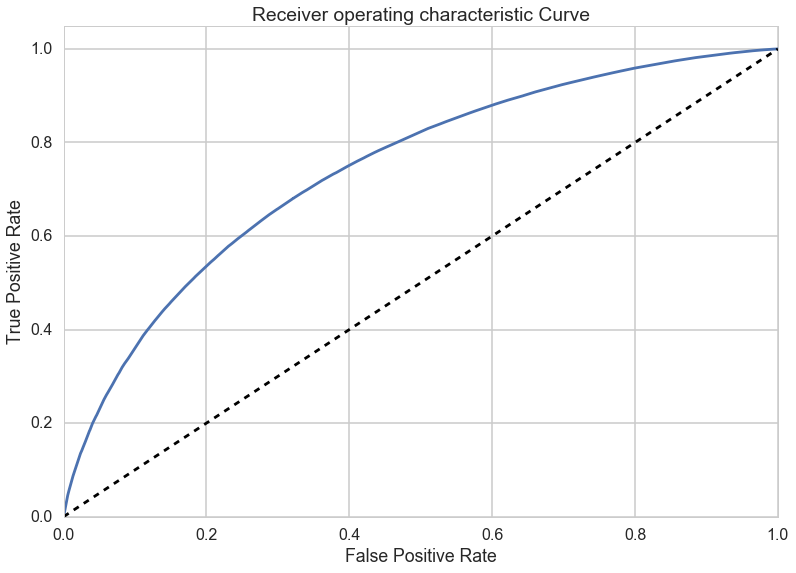

Area under ROC:  0.743007002469
Precision, Recall, Fscore:
(0.76792679051223534, 0.8963084108210182, 0.82716582449343179, None)
Confusion Matrix:
[[212642  24600]
 [ 64262  36929]]


In [20]:
# Load projects data from csv
projects = load_projects()

# Wrangle Data 
projects, projects_label = data_wrangling(projects)

# Get input features to be used on a model
feature_array = prepare_features(projects,projects_label)

# Prepare Training and testing Data ( 60% training and 40% testing)
mask = create_train_test_data(projects_label,0.60)

# Define and Run Random Forest model over the specified parameters (GridSearchCV)
from sklearn.ensemble import RandomForestClassifier
clfForest = RandomForestClassifier()

# Define all parameters to be used while doing a GridSearchCV to find the best for the classifier
parameters = {"n_estimators": range(20, 40), "min_samples_split":[1,2,4,6], "max_depth":range(20, 50)}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, 
                                                       projects, feature_array,'funding_status', 'completed', mask=mask, 
                                                       n_jobs = 4, score_func='f1')

# Performance results - ROC, AUC, Precision, Recall, Confusion Matrix
classifier_performance(clfForest,Xtest,ytest)